# Setup

In [1]:
import os 
os.chdir('/home/imendoza/bliss')

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import sklearn
import torch

from bliss.datasets import sdss
from bliss.reporting import scene_metrics, plot_image, get_params_from_coadd
from bliss.predict import predict_on_scene

from astropy.table import Table

In [5]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [6]:
# check GPU is configured correctly
!export CUDA_VISIBLE_DEVICES="1"
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

3


# Load data

In [7]:
bp = 24
clen = 300
pixel_scale=0.396
run = 94
camcol = 1
field = 12
bands = (2,)
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=run,
    camcol=camcol,
    fields=(field,),
    bands=bands,
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

wcs = sdss_data[0]['wcs'][0]
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()
scene = sdss_data[0]["image"][0]
h,w = scene.shape[-2], scene.shape[-1]
print(h, w)

1489 2048


In [8]:
# load coadd catalog
coadd_catalog_file = 'data/coadd_catalog_94_1_12.fits'
psf_image_file = 'data/psField-000094-1-0012-PSF-image.npy'
# add_extra_coadd_info(coadd_catalog_file, psf_image_file, pixel_scale, wcs)

In [9]:
coadd_cat = Table.read(coadd_catalog_file, format='fits')
coadd_params = get_params_from_coadd(coadd_cat, h, w, bp)

# Load models

In [12]:
from bliss.models.binary import BinaryEncoder
from bliss.models.galaxy_encoder import GalaxyEncoder
from bliss.sleep import SleepPhase

In [13]:
# prepare BLISS model 
sleep_file = '/home/imendoza/bliss/models/sdss_sleep.ckpt'
galaxy_encoder_file = '/home/imendoza/bliss/models/sdss_galaxy_encoder.ckpt'
binary_file = '/home/imendoza/bliss/models/sdss_binary.ckpt'


# load models
sleep_net = SleepPhase.load_from_checkpoint(sleep_file).to('cpu')
image_encoder= sleep_net.image_encoder.to(device).eval()
binary_encoder = BinaryEncoder.load_from_checkpoint(binary_file).to(device).eval()
galaxy_encoder = GalaxyEncoder.load_from_checkpoint(galaxy_encoder_file).to(device).eval()
galaxy_decoder = sleep_net.image_decoder.galaxy_tile_decoder.galaxy_decoder.eval().to(device)

# Prediction

In [14]:
torch.cuda.empty_cache()

In [15]:
# predict using models 

clen = 300
_scene = torch.from_numpy(scene).reshape(1, 1, h, w)
_, est_params = predict_on_scene(clen, _scene, image_encoder, binary_encoder, 
                                 galaxy_encoder, galaxy_decoder, device) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:47<00:00,  1.36s/it]


## Check locations are sensible using plotly

In [16]:
# import plotly.express as px
# import plotly.graph_objects as go

# fig = px.imshow(scene, zmin=800, zmax=900)
# fig.update_layout(width=800, height=800)
# plocs = est_params['plocs'].cpu().numpy()
# scatter_true = go.Scatter(name='coadd', x=coadd_params['x'], y=coadd_params['y'], mode='markers', marker=dict(color='blue', size=8, symbol='x'))
# scatter_est = go.Scatter(name='estimate', x=plocs[:, 0], y=plocs[:, 1], mode='markers', marker=dict(color='red', size=9, symbol='circle'))

# fig.add_trace(scatter_true)
# fig.add_trace(scatter_est)
# fig.show()

# Results

In [18]:
# max mag in est_params ~ 22.5
print(h, w, bp)
# extract 'true' parameters based on coadd catalog.
coadd_params = get_params_from_coadd(coadd_cat, h, w, bp)
scene_metrics(coadd_params, est_params, mag_cut=21, slack=1.0, mag_slack=0.5)

1489 2048 24


{'precision': tensor(0.8121),
 'recall': tensor(0.7540),
 'f1': tensor(0.7820),
 'class_acc': tensor(0.9574),
 'conf_matrix': tensor([[122,  11],
         [  0, 125]])}

# Plot

## Collect for all magnitude bins

In [19]:
mag_bins = np.arange(18, 23, 0.1) #skip 23
precisions = [] 
recalls = []
class_accs = [] 
for mag in mag_bins: 
    res = scene_metrics(coadd_params, est_params, mag_cut=mag, slack=1.0, mag_slack=0.5)
    precisions.append(res['precision'].item())
    recalls.append(res['recall'].item())
    class_accs.append(res['class_acc'].item())

## lineplot

In [31]:
import seaborn as sns
from plot_defaults import set_rc_params, format_plot, CB_color_cycle
sns.set_theme(style="darkgrid")

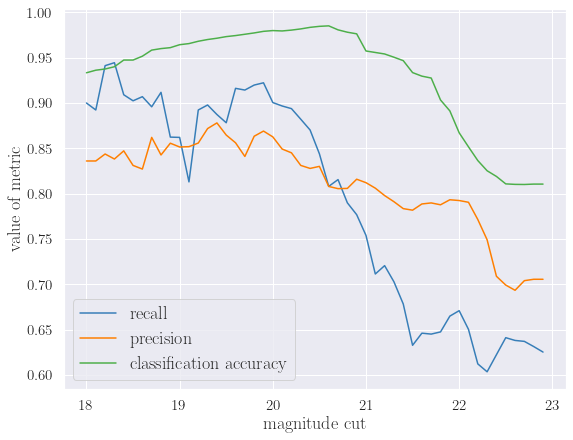

In [32]:
%matplotlib inline
set_rc_params(tick_label_size='small', label_size='medium')
f, ax = plt.subplots(1, 1, figsize=(9, 7))
format_plot(ax, xlabel=r'\rm magnitude cut', ylabel=r'value of metric')
ax.plot(mag_bins, recalls, label=r'\rm recall')
ax.plot(mag_bins, precisions, label=r'\rm precision')
ax.plot(mag_bins, class_accs, label=r'\rm classification accuracy')
ax.legend()
plt.show()

Text(0.5, 0, 'true mag.')

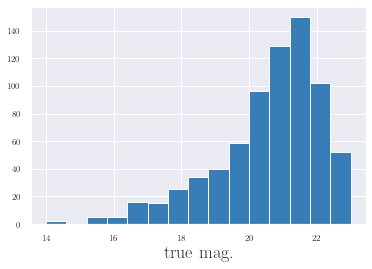

In [121]:
%matplotlib inline
plt.hist(coadd_params['mag'].numpy(), bins=15, range=(14, 23))
plt.xlabel('true mag.', size=18)

Text(0.5, 0, 'est mag.')

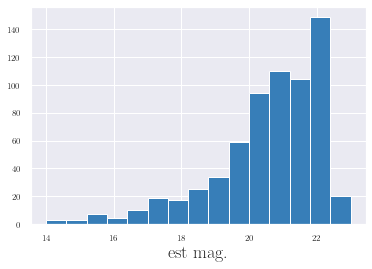

In [122]:
%matplotlib inline
plt.hist(est_params['mag'].numpy(), bins=15, range=(14, 23))
plt.xlabel('est mag.', size=18)